In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.sparse
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Lambda, Activation, Embedding, Input, Dense, Reshape, Flatten, Dropout, Multiply, Concatenate, Dot

%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')


# Testing Matrix Factorization model on the MovieLends 1M dataset

### Download and load MovieLens 1M dataset

In [3]:
import requests, zipfile, os
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'
if not os.path.exists(os.path.join(data_dir, zip_name)):
  r = requests.get(url, allow_redirects=True)
  open(zip_name, 'wb').write(r.content)

  with zipfile.ZipFile(zip_name,"r") as zip_ref:
      zip_ref.extractall()

In [4]:
ratings_file = "ml-1m/ratings.dat"
cols_data = ['user_id', 'item_id', 'rating', 'timestamp']

df_ratings = pd.read_csv(ratings_file, delimiter='::', header=None, names=cols_data)
df_ratings

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### Split train/test 80%/20%

In [5]:
df_ratings_train, df_ratings_test = train_test_split(df_ratings,   
                                     test_size=0.2)

print(df_ratings_train.shape, df_ratings_test.shape)

(800167, 4) (200042, 4)


### Build the model

In [6]:
class MFModel:
  def __init__(self, n_users, n_items):
    self.n_users = n_users
    self.n_items = n_items
    self.model = None
    self.history = None

  def compute_masked_loss(self, y_true, y_pred):
    # ignore the missing value (having value of zero) in loss computation
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    mask_true = tf.cast(tf.not_equal(y_true, 0), tf.float32) 

    error = y_true - y_pred

    se = tf.square(error) * mask_true
    mse = tf.reduce_sum(se) / tf.reduce_sum(mask_true)
    return mse 

  def masked_rmse_loss(self, y_true, y_pred):
    return tf.math.sqrt(self.compute_masked_loss(y_true, y_pred))
    
  def fit(self,x, y, latent_dim=10, lr=0.001, batch_size=128, epochs=500, verbose=1):
    print(f"Fitting MF model with latent_dim={latent_dim}, batch_size={batch_size}, learning_rate={lr}, epochs={epochs}")

    model = self.get_MF_model(latent_dim)
    adam = keras.optimizers.Adam(lr=lr)
    model.compile(adam, loss=self.compute_masked_loss, metrics=[self.masked_rmse_loss])
    
    history = model.fit(x=x, y=y,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_split=0.1,
                                      verbose=verbose)
        
    self.model = model
    self.history = history

    return model

  def get_MF_model(self, latent_dim):
      # Input variables
      user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
      item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

      MF_Embedding_User = Embedding(input_dim = self.n_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
      MF_Embedding_Item = Embedding(input_dim = self.n_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
      
      # Crucial to flatten an embedding vector!
      user_latent = Flatten()(MF_Embedding_User(user_input))
      item_latent = Flatten()(MF_Embedding_Item(item_input))
      
      # Element-wise product of user and item embeddings
      prediction = keras.layers.dot([user_latent,item_latent], axes=1,normalize=False)
      
      
      model = keras.Model(inputs=[user_input, item_input], outputs=prediction)
      
      return model
  
  def plot_loss_history(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()

  def prediction_matrix(self):
    items_embeddings = self.model.get_layer(name='item_embedding').get_weights()[0]
    users_embeddings = self.model.get_layer(name='user_embedding').get_weights()[0]

    return users_embeddings @ items_embeddings.T

  def ndcg_score(self, df_true, df_pred):
    diff_rows = df_pred.shape[0] - df_true.shape[0]
    diff_cols = df_pred.shape[1] - df_true.shape[1]
    
    z = np.zeros((diff_rows, df_true.shape[1]))
    df_true = np.append(df_true, z,axis=0)

    z = np.zeros((df_true.shape[0], diff_cols))
    df_true = np.append(df_true, z,axis=1)

    return ndcg_score(df_true, df_pred)

In [7]:
n_users = df_ratings['user_id'].max() + 1
n_movies = df_ratings['item_id'].max() + 1

print(n_users, n_movies)
mf_model = MFModel(n_users, n_movies)

model = mf_model.get_MF_model(10)

model.summary()

6041 3953
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60410       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        39530       item_input[0][0]                 
____________________________________________________________________________________

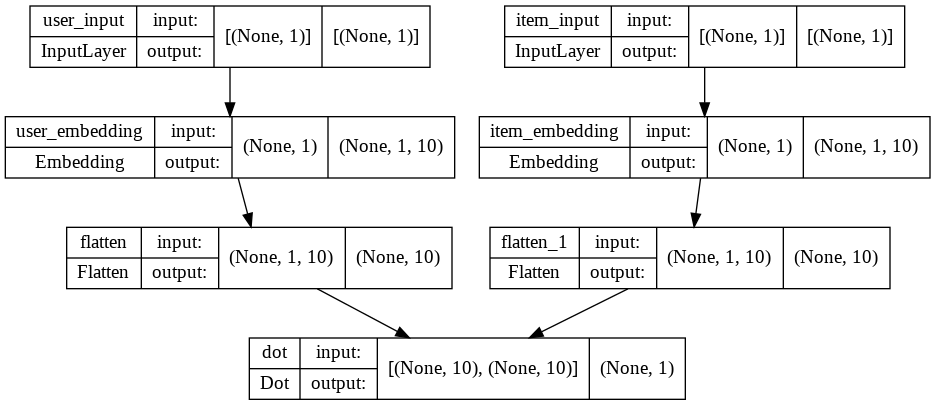

In [8]:
keras.utils.plot_model(model, show_shapes=True)


In [8]:
mf_model.fit(x=[df_ratings_train.user_id.values, df_ratings_train.item_id.values],
                    y=df_ratings_train.rating.values,
                    batch_size=128,
                    epochs=5)

Fitting MF model with latent_dim=10, batch_size=128, learning_rate=0.001, epochs=5
Epoch 1/5
5627/5627 [==============================] - 6s 859us/step - loss: 5.7144 - masked_rmse_loss: 2.1694 - val_loss: 1.2268 - val_masked_rmse_loss: 1.1050
Epoch 2/5
5627/5627 [==============================] - 5s 860us/step - loss: 0.9808 - masked_rmse_loss: 0.9873 - val_loss: 0.8963 - val_masked_rmse_loss: 0.9443
Epoch 3/5
5627/5627 [==============================] - 5s 865us/step - loss: 0.8660 - masked_rmse_loss: 0.9285 - val_loss: 0.8659 - val_masked_rmse_loss: 0.9283
Epoch 4/5
5627/5627 [==============================] - 5s 862us/step - loss: 0.8498 - masked_rmse_loss: 0.9198 - val_loss: 0.8578 - val_masked_rmse_loss: 0.9240
Epoch 5/5
5627/5627 [==============================] - 5s 850us/step - loss: 0.8382 - masked_rmse_loss: 0.9135 - val_loss: 0.8431 - val_masked_rmse_loss: 0.9160


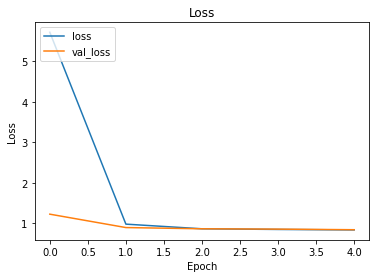

In [9]:
mf_model.plot_loss_history()

In [10]:
print("Model RMSE on train:", mf_model.history.history['masked_rmse_loss'][-1])
print("Model RMSE on validation:", mf_model.history.history['val_masked_rmse_loss'][-1])

Model RMSE on train: 0.9135416150093079
Model RMSE on validation: 0.9160395264625549


## Hyper-parameter tuning

In [17]:
import time

latent_factors = [5, 10, 20]
batch_sizes = [ 128, 256, 512 ]
learning_rates  = [0.001, 0.01, 0.1]
epochs = 5 # Only one value due to computational power

results = pd.DataFrame(columns=['Epochs', 'Batch size', 'Latent_factors', 'Learning Rate', 'Validation RMSE', 'Time'])

val_errors = {}
train_errors = {}

model_i = 1

print(f"Training {len(latent_factors) * len(batch_sizes) * len(learning_rates)} models for Hyper-parameter tuning...")

for bs in batch_sizes:
  for k in latent_factors:
    for lr in learning_rates:
      print(f"Model {model_i}")
      dic = {'Epochs':epochs, 'Latent_factors':k, 'Batch size': bs, 'Learning Rate':lr}
      
      start = time.time()
      mfmodel = mf_model.fit(x=[df_ratings_train.user_id.values, df_ratings_train.item_id.values],
                    y=df_ratings_train.rating.values,
                    batch_size=bs,
                    lr=lr,
                    latent_dim=k,
                    epochs=epochs,
                    verbose=0)
      
      dic['Time'] = time.time() - start
      dic['Validation RMSE'] = mfmodel.history.history['val_masked_rmse_loss'][1]

      results = results.append(dic, ignore_index=True)
      model_i += 1 

results


Training 27 models for Hyper-parameter tuning...
Model 1
Fitting MF model with latent_dim=5, batch_size=128, learning_rate=0.001, epochs=5
Model 2
Fitting MF model with latent_dim=5, batch_size=128, learning_rate=0.01, epochs=5
Model 3
Fitting MF model with latent_dim=5, batch_size=128, learning_rate=0.1, epochs=5
Model 4
Fitting MF model with latent_dim=10, batch_size=128, learning_rate=0.001, epochs=5
Model 5
Fitting MF model with latent_dim=10, batch_size=128, learning_rate=0.01, epochs=5
Model 6
Fitting MF model with latent_dim=10, batch_size=128, learning_rate=0.1, epochs=5
Model 7
Fitting MF model with latent_dim=20, batch_size=128, learning_rate=0.001, epochs=5
Model 8
Fitting MF model with latent_dim=20, batch_size=128, learning_rate=0.01, epochs=5
Model 9
Fitting MF model with latent_dim=20, batch_size=128, learning_rate=0.1, epochs=5
Model 10
Fitting MF model with latent_dim=5, batch_size=256, learning_rate=0.001, epochs=5
Model 11
Fitting MF model with latent_dim=5, batch_si

,Epochs,Batch size,Latent_factors,Learning Rate,Validation RMSE,Time
0,5.0,128.0,5.0,0.001,0.983407,20.942778
1,5.0,128.0,5.0,0.010,0.968262,19.324331
2,5.0,128.0,5.0,0.100,2.467733,19.023690
3,5.0,128.0,10.0,0.001,0.945021,21.981126
4,5.0,128.0,10.0,0.010,1.001785,20.472110
5,5.0,128.0,10.0,0.100,4.360367,20.470827
6,5.0,128.0,20.0,0.001,0.922240,28.306251
7,5.0,128.0,20.0,0.010,1.069176,27.228407
8,5.0,128.0,20.0,0.100,9.956422,26.984426
9,5.0,256.0,5.0,0.001,1.060585,9.571615


In [43]:
results.loc[results['Validation RMSE'].nsmallest(3).index,:]

,Epochs,Batch size,Latent_factors,Learning Rate,Validation RMSE,Time
6,5.0,128.0,20.0,0.001,0.922240,28.306251
15,5.0,256.0,20.0,0.001,0.937707,13.586310
19,5.0,512.0,5.0,0.010,0.940366,5.184345


In [20]:
best_params = results.loc[6]
best_params

Epochs               5.000000
Batch size         128.000000
Latent_factors      20.000000
Learning Rate        0.001000
Validation RMSE      0.922240
Time                28.306251
Name: 6, dtype: float64

In [21]:
# Train best model
best_model = mf_model.fit(x=[df_ratings_train.user_id.values, df_ratings_train.item_id.values],
                    y=df_ratings_train.rating.values,
                    lr=float(best_params["Learning Rate"]),
                    batch_size=int(best_params["Batch size"]),
                    latent_dim=int(best_params["Latent_factors"]),
                    epochs=epochs,
                    verbose=0)

Fitting MF model with latent_dim=20, batch_size=128, learning_rate=0.001, epochs=5


In [24]:
test_rmse = mf_model.model.evaluate(x=[df_ratings_test.user_id.values, df_ratings_test.item_id.values],
                    y=df_ratings_test.rating.values, batch_size=128)[1]

print("Model RMSE on test:", test_rmse)


1563/1563 [==============================] - 1s 514us/step - loss: 0.8179 - masked_rmse_loss: 0.9023
Model RMSE on test: 0.9022892117500305


In [25]:
predicted_matrix = mf_model.prediction_matrix()

pd.DataFrame(predicted_matrix)

,0,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,-0.000163,-0.036689,-0.055851,-0.056718,-0.031452,-0.056809,-0.016198,-0.044603,-0.050994,-0.031948,...,-0.015864,-0.015996,-0.022439,-0.037598,-0.015617,-0.051575,-0.027153,-0.031844,-0.030635,-0.043202
1,0.122090,4.478780,3.620851,3.333691,3.140452,3.488681,4.032313,3.779960,3.514455,2.996306,...,3.148469,1.332958,1.460552,2.521659,4.138412,4.077322,4.303056,4.023399,4.523640,4.230690
2,0.133221,4.206234,3.537250,3.315630,3.043194,3.444322,3.813392,3.692276,3.399695,2.946761,...,2.979637,1.250622,1.410238,2.443828,3.946873,3.882584,4.023319,3.810337,4.333279,4.031531
3,0.125714,4.175943,3.495358,3.309561,3.015178,3.407001,3.729233,3.692008,3.373299,2.910611,...,2.950831,1.250649,1.417515,2.451302,3.901329,3.874648,3.938801,3.789309,4.305028,4.018425
4,0.112642,4.047594,3.209181,2.953942,2.837580,3.100636,3.703443,3.378192,3.210665,2.707416,...,2.871567,1.245501,1.327316,2.212095,3.804268,3.675826,4.002931,3.689259,4.138574,3.838430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.065383,4.046297,2.533696,2.100367,2.279036,2.284727,3.574583,2.590656,2.594061,2.068407,...,2.781553,1.148204,1.098733,1.746651,3.474965,3.253278,3.938078,3.303203,3.548710,3.471963
6037,0.099276,4.131533,3.135549,2.836729,2.683849,2.972326,3.671583,3.205517,3.024545,2.597379,...,2.943736,1.198410,1.286764,2.183541,3.704859,3.680045,3.937923,3.564096,3.984023,3.802648
6038,0.121338,4.076929,3.455691,3.216615,2.971346,3.336280,3.736923,3.628129,3.351591,2.868882,...,2.892060,1.260747,1.383012,2.350956,3.870608,3.802813,3.971370,3.752463,4.269765,3.945238
6039,0.112576,4.051123,3.272479,3.023120,2.865003,3.149292,3.710009,3.434824,3.207245,2.735008,...,2.900778,1.198170,1.320699,2.273840,3.793218,3.669500,3.931875,3.665307,4.149896,3.862095


In [26]:
test_user_item_matrix = df_ratings_test.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

print("NDCG Score on test:", mf_model.ndcg_score(test_user_item_matrix, predicted_matrix))

NDCG Score on test: 0.26940170957476056


# Testing Matrix Factorization model on the Steam 200K Games Dataset:

### Data loading and Preprocessing

In [27]:
steam_ratings = pd.read_csv('steam-200k.csv', index_col=None, header=None)
steam_ratings.columns=['user_id', 'game', 'action', 'hours', 'none']
steam_ratings = steam_ratings.drop('none', axis=1)

# Group interations by user_id and game
steam_ratings = steam_ratings.groupby(['user_id', 'game'])\
                                      .sum()['hours'].reset_index()

steam_ratings['view'] = 1 
steam_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,7.7,1
128800,309812026,Counter-Strike Nexon Zombies,1.0,1
128801,309812026,Robocraft,1.0,1
128802,309824202,Dota 2,1.7,1


Remove users that had less than 5 interactions

In [28]:
min_interactions = 5
users_interactions_count_df = steam_ratings.groupby('user_id').size()
valid_user_ids = users_interactions_count_df[users_interactions_count_df >= min_interactions].reset_index()[['user_id']]
filtered_ratings = steam_ratings.merge(valid_user_ids, how = 'right', left_on = 'user_id', right_on = 'user_id')
filtered_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
115134,309404240,AdVenture Capitalist,1.7,1
115135,309404240,Mitos.is The Game,3.2,1
115136,309404240,Team Fortress 2,3.2,1
115137,309404240,Transformice,1.3,1


In [29]:
# Add user ID and item ID fields
filtered_ratings['item_id'] = filtered_ratings['game'].astype('category').cat.codes
filtered_ratings['user_id'] = filtered_ratings['user_id'].astype('category').cat.codes
print("Total users:", filtered_ratings.groupby("user_id").sum("view").shape[0])

filtered_ratings = filtered_ratings[['user_id','item_id','game','hours','view']]
filtered_ratings.head(5)

Total users: 3757


,user_id,item_id,game,hours,view
0,0,226,Alien Swarm,5.9,1
1,0,846,Cities Skylines,145.0,1
2,0,972,Counter-Strike,1.0,1
3,0,978,Counter-Strike Source,1.0,1
4,0,1125,Day of Defeat,1.0,1


Split dataset to 80% Train, 20% Test

In [30]:
 # Create a DataFrame with Content Information
games_df = filtered_ratings.groupby(['game', 'item_id'])\
                                    .agg({'user_id': 'count', 'hours': np.sum})[['user_id','hours']]\
                                    .reset_index()\
                                    .rename(columns={'user_id': 'total_users', 'hours': 'total_hours'})


games_df = games_df[['item_id', 'game','total_users','total_hours']]
games_df      

,item_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6
...,...,...,...,...
5108,5108,sZone-Online,95,147.7
5109,5109,samurai_jazz,1,1.0
5110,5110,the static speaks my name,13,15.0
5111,5111,theHunter,220,515.3


In [31]:
# Split dataset in Train/Test
train_df, test_df = train_test_split(filtered_ratings,
                                                 test_size=0.2,
                                    )  
print("Train/test split:", train_df.shape, test_df.shape)

Train/test split: (92111, 5) (23028, 5)


## Building the model

In [32]:
n_users = filtered_ratings['user_id'].max() +1
n_games = filtered_ratings['item_id'].max() +1
print("Got", n_users, "users and ", n_games, "items")
mf_model = MFModel(n_users, n_games)

Got 3757 users and  5113 items


In [38]:
mf_model.fit(x=[train_df.user_id.values, train_df.item_id.values],
                    y=train_df.view.values,
                    lr=float(best_params["Learning Rate"]),
                    batch_size=int(best_params["Batch size"]),
                    latent_dim=int(best_params["Latent_factors"]),
                    epochs=epochs
                    )

Fitting MF model with latent_dim=20, batch_size=128, learning_rate=0.001, epochs=5
Epoch 1/5
648/648 [==============================] - 1s 1ms/step - loss: 0.9340 - masked_rmse_loss: 0.9648 - val_loss: 0.6201 - val_masked_rmse_loss: 0.7874
Epoch 2/5
648/648 [==============================] - 1s 1ms/step - loss: 0.2699 - masked_rmse_loss: 0.5057 - val_loss: 0.1307 - val_masked_rmse_loss: 0.3607
Epoch 3/5
648/648 [==============================] - 1s 1ms/step - loss: 0.0737 - masked_rmse_loss: 0.2689 - val_loss: 0.0608 - val_masked_rmse_loss: 0.2453
Epoch 4/5
648/648 [==============================] - 1s 1ms/step - loss: 0.0309 - masked_rmse_loss: 0.1739 - val_loss: 0.0365 - val_masked_rmse_loss: 0.1891
Epoch 5/5
648/648 [==============================] - 1s 1ms/step - loss: 0.0149 - masked_rmse_loss: 0.1202 - val_loss: 0.0261 - val_masked_rmse_loss: 0.1587


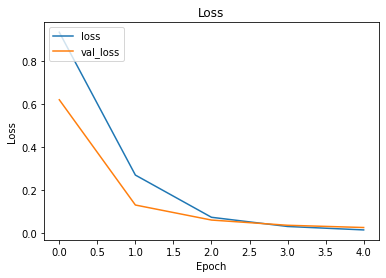

In [39]:
mf_model.plot_loss_history()

## Model evaluation on test set

In [40]:
print("RMSE on test:", mf_model.model.evaluate(x=[test_df.user_id.values, test_df.item_id.values],
                    y=test_df.view.values, batch_size=128)[1])

180/180 [==============================] - 0s 590us/step - loss: 0.0287 - masked_rmse_loss: 0.1664
RMSE on test: 0.16638457775115967


In [41]:
predicted_matrix = mf_model.prediction_matrix()
pd.DataFrame(predicted_matrix)

,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
0,0.366258,0.514406,0.717436,0.688289,0.286900,0.876941,0.507617,0.828255,0.848577,0.637911,...,-0.023798,0.725993,0.571025,0.862230,-0.041260,0.921356,0.031632,0.886912,0.898946,0.628994
1,0.385081,0.568512,0.776507,0.742980,0.310019,0.950544,0.554082,0.903803,0.926139,0.702217,...,-0.037026,0.797741,0.617912,0.920463,-0.036294,0.995127,0.035125,0.973731,0.983528,0.687989
2,0.400528,0.602960,0.846335,0.815861,0.346642,0.970028,0.565320,0.949444,0.963907,0.747788,...,-0.030186,0.859269,0.646344,0.979935,-0.046506,1.086384,0.033359,1.042261,1.063925,0.710781
3,0.249222,0.304327,0.440558,0.425625,0.156788,0.567011,0.277116,0.500907,0.504463,0.375739,...,-0.010826,0.394493,0.333921,0.510246,-0.026991,0.507976,0.017728,0.482951,0.448067,0.369769
4,0.227347,0.276315,0.403605,0.389079,0.144887,0.525248,0.235381,0.459926,0.459302,0.353665,...,-0.008708,0.354800,0.307523,0.473085,-0.025493,0.426031,0.020030,0.421518,0.371926,0.321564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,0.278765,0.420976,0.597932,0.579492,0.230718,0.675224,0.455559,0.686692,0.701100,0.542329,...,-0.011416,0.626959,0.452869,0.687917,-0.030735,0.918111,0.022184,0.856115,0.986167,0.541827
3753,0.298142,0.462524,0.684940,0.650260,0.266891,0.743513,0.481425,0.752753,0.778651,0.610579,...,-0.022930,0.705003,0.502123,0.757503,-0.030017,0.996503,0.030149,0.915368,1.049568,0.589031
3754,0.287145,0.435425,0.614720,0.594265,0.236988,0.689865,0.456968,0.693377,0.717110,0.544728,...,-0.016081,0.642273,0.455311,0.685858,-0.022896,0.960227,0.026134,0.860016,0.977416,0.559611
3755,0.327347,0.470379,0.669504,0.650038,0.268903,0.766882,0.485696,0.760162,0.778979,0.609974,...,-0.007737,0.695175,0.516550,0.776062,-0.037060,0.974308,0.029379,0.919955,1.034313,0.587675


In [42]:
# Convert the test dataset to a user x item matrix
test_user_item_matrix = test_df.pivot(index='user_id', columns='item_id', values='view').fillna(0)

print("NDCG Score on test:", mf_model.ndcg_score(test_user_item_matrix, predicted_matrix))

NDCG Score on test: 0.13621086154260628
